<a href="https://colab.research.google.com/github/manuelboi/AI_project/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
def show_single_letter(xi):
  #
  #plt.figure(figsize=(1,1))
  # take pytorch tensor and convert it into numpy array, then reshape into 28x28
  xi = xi.numpy().reshape(28, 28)
  # show the transpose of the grey-scale images
  plt.imshow(np.transpose(xi), cmap='Greys')
  plt.axis("off")

def show_letters(x, n=10):
  for i in range(n**2):
    plt.subplot(n, n, i+1)
    show_single_letter(x[i])


input_size = 28 * 28
num_classes = 26

# 124800 training set images
train_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                        train=True, download=True,
                                        transform=transforms.ToTensor())

# 20800 test set images
test_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                       train=False,
                                       transform=transforms.ToTensor())
# tr_images and labels are tensors
tr_images = train_set.data
labels = train_set.targets



# plot a single image
#show_single_letter(tr_images[0])

# show_letters(tr_images, 12)




100%|██████████| 561753746/561753746 [00:07<00:00, 79435563.90it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


# Nuova sezione

Understanding tensors

In [ ]:
print(tr_images)
print(tr_images.size())
print(tr_images[0])
print(tr_images[0].size())

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

Matteo - Implementazione della maschera per scheletrizzazione

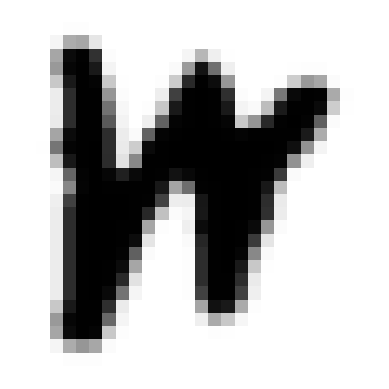

In [ ]:
show_single_letter(tr_images[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0],
        [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0],
        [  0,   0,   0, 255, 255, 255, 255, 25

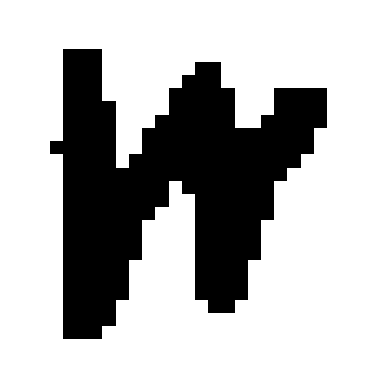

In [ ]:
thresh = 128
maxval=255

im_bin = (tr_images[0] > thresh)*maxval
print(im_bin)
show_single_letter(im_bin)
